# Exploratory Data Analysis (EDA)

This notebook performs a comprehensive EDA on the financial news dataset, covering descriptive statistics, text analysis, time series analysis, and publisher analysis.

In [2]:
import sys
import os
import pandas as pd

# Add the parent directory to sys.path to allow imports from src
sys.path.append(os.path.abspath(os.path.join('..')))

from src.fnsa.data.loader import load_data
from src.fnsa.data.preprocessing import convert_to_datetime, handle_missing_values, remove_duplicates
from src.fnsa.features.builder import add_headline_length, get_publisher_counts, get_articles_per_date, add_publication_time_features, extract_publisher_domains
from src.fnsa.features.text_analysis import get_common_phrases, perform_topic_modeling
from src.fnsa.utils.plotting import PlotHelper
from config.settings import settings

In [3]:
# Initialize PlotHelper
plotter = PlotHelper()

# Load Data
data_path = settings.RAW_DATA_DIR / settings.RAW_DATA_FILE
print(f"Loading data from {data_path}")

try:
    df = load_data(str(data_path))
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File not found: {data_path}. Using dummy data.")
    df = pd.DataFrame({
        'headline': ['Stock A rises', 'Stock B falls', 'Market update', 'Stock A report', 'FDA approval for Drug X', 'Earnings report Q3'],
        'publisher': ['Pub1', 'Pub2', 'Pub1', 'Pub3', 'user@domain.com', 'another@domain.com'],
        'date': ['2023-01-01 10:00', '2023-01-02 11:00', '2023-01-01 12:00', '2023-01-03 09:00', '2023-01-04 14:00', '2023-01-05 15:00']
    })

# Preprocessing
df = convert_to_datetime(df, 'date')
df = handle_missing_values(df, strategy='drop')
df = remove_duplicates(df)
print(f"Data shape after preprocessing: {df.shape}")

Loading data from c:\BackUp\web-projects\tenx\finance-challange-week1\data\raw\raw_analyst_ratings.csv
Data loaded successfully.
Data shape after preprocessing: (55987, 6)


## 1. Descriptive Statistics

### Textual Lengths (Headline Length)

       headline_length
count     55987.000000
mean         80.015254
std          56.126094
min          12.000000
25%          42.000000
50%          63.000000
75%          91.000000
max         512.000000


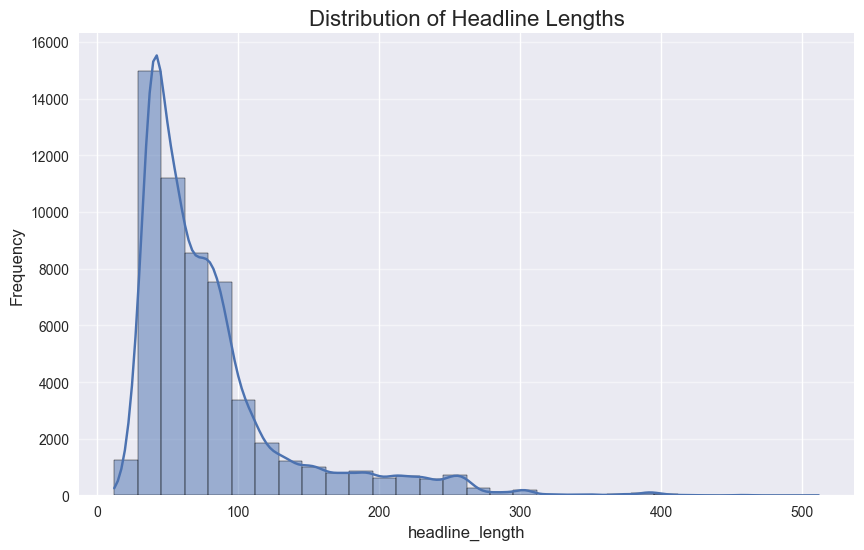

In [4]:
df = add_headline_length(df)
print(df[['headline', 'headline_length']].describe())
plotter.histogram(df, column='headline_length', title='Distribution of Headline Lengths')

### Articles per Publisher

Top 10 Publishers:
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


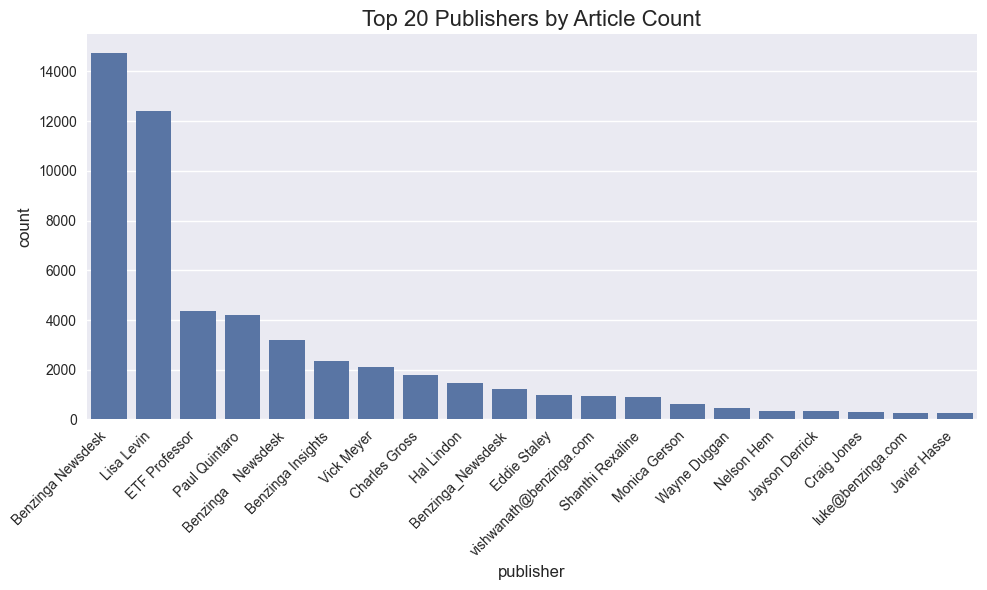

In [5]:
publisher_counts = get_publisher_counts(df)
print("Top 10 Publishers:")
print(publisher_counts.head(10))

top_publishers = publisher_counts.head(20).reset_index()
top_publishers.columns = ['publisher', 'count']
plotter.bar(top_publishers, x='publisher', y='count', title='Top 20 Publishers by Article Count')

### Publication Dates Trends

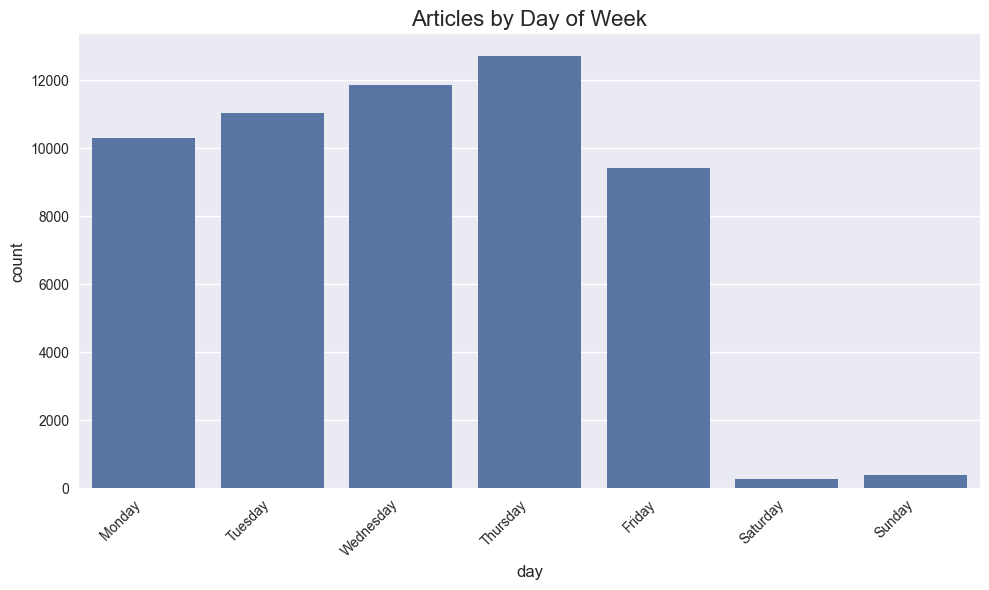

In [6]:
df = add_publication_time_features(df)

# Articles by Day of Week
day_counts = df['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()
day_counts.columns = ['day', 'count']
plotter.bar(day_counts, x='day', y='count', title='Articles by Day of Week')

## 2. Text Analysis (Topic Modeling)

### Common Keywords and Phrases

In [7]:
print("Top 20 Common Unigrams:")
common_unigrams = get_common_phrases(df, 'headline', n=20, ngram_range=(1, 1))
print(common_unigrams)

print("\nTop 20 Common Bigrams:")
common_bigrams = get_common_phrases(df, 'headline', n=20, ngram_range=(2, 2))
print(common_bigrams)

Top 20 Common Unigrams:
[('stocks', np.int64(12794)), ('week', np.int64(9029)), ('52', np.int64(8453)), ('shares', np.int64(8393)), ('trading', np.int64(6575)), ('hit', np.int64(5902)), ('eps', np.int64(5531)), ('market', np.int64(5482)), ('price', np.int64(5046)), ('companies', np.int64(4778)), ('target', np.int64(4676)), ('sales', np.int64(4429)), ('higher', np.int64(4271)), ('estimate', np.int64(3818)), ('lows', np.int64(3741)), ('session', np.int64(3394)), ('maintains', np.int64(3266)), ('new', np.int64(3110)), ('yesterday', np.int64(3067)), ('q1', np.int64(3019))]

Top 20 Common Bigrams:
[('52 week', np.int64(8251)), ('stocks hit', np.int64(5847)), ('hit 52', np.int64(5846)), ('price target', np.int64(4585)), ('companies trading', np.int64(4082)), ('week lows', np.int64(3687)), ('trading higher', np.int64(3517)), ('stocks moving', np.int64(2841)), ('week highs', np.int64(2561)), ('trading lower', np.int64(2152)), ('new 52', np.int64(2095)), ('set new', np.int64(2057)), ('stocks se

### Topic Modeling

In [8]:
topics = perform_topic_modeling(df, 'headline', n_topics=5, n_top_words=10)
print("Identified Topics:")
for topic_idx, words in topics.items():
    print(f"Topic {topic_idx + 1}: {', '.join(words)}")

Identified Topics:
Topic 1: highs, 52, week, hit, stocks, friday, tuesday, wednesday, monday, set
Topic 2: moving, session, stocks, day, pre, mid, market, wednesday, tuesday, monday
Topic 3: movers, biggest, yesterday, set, new, low, friday, 70, october, 2018
Topic 4: trading, shares, companies, higher, amid, optimism, following, reopening, economic, economy
Topic 5: lows, hit, 52, thursday, week, stocks, friday, monday, wednesday, tuesday


## 3. Time Series Analysis

### Publication Frequency Over Time

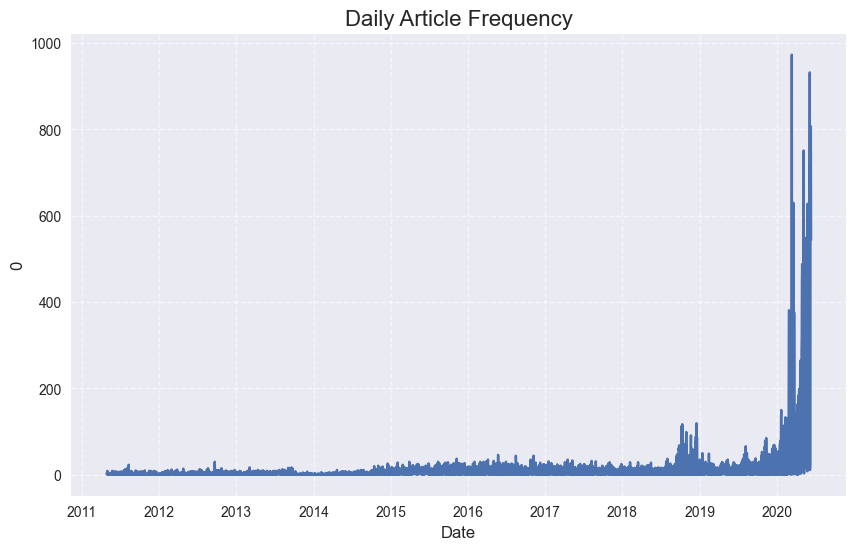


Potential Event Spikes (Dates with high volume):
date
2020-01-22 00:00:00+00:00    150
2020-02-27 00:00:00+00:00    275
2020-02-28 00:00:00+00:00    381
2020-03-05 00:00:00+00:00    138
2020-03-06 00:00:00+00:00    281
                            ... 
2020-06-05 00:00:00+00:00    932
2020-06-08 00:00:00+00:00    765
2020-06-09 00:00:00+00:00    803
2020-06-10 00:00:00+00:00    807
2020-06-11 00:00:00+00:00    544
Length: 61, dtype: int64


In [9]:
articles_per_day = get_articles_per_date(df, freq='D')
plotter.line(articles_per_day, x='date', y=0, title='Daily Article Frequency')

# Identify spikes (simple threshold, e.g., > mean + 2*std)
mean_daily = articles_per_day.mean()
std_daily = articles_per_day.std()
spikes = articles_per_day[articles_per_day > mean_daily + 2 * std_daily]
print("\nPotential Event Spikes (Dates with high volume):")
print(spikes)

### Analysis of Publishing Times (Time of Day)

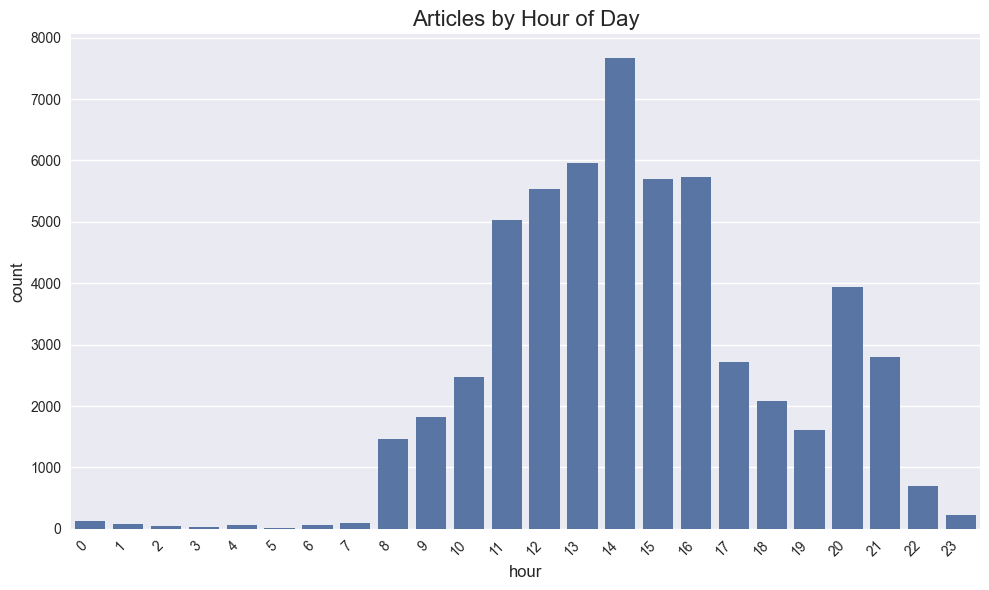

In [10]:
hour_counts = df['hour'].value_counts().sort_index().reset_index()
hour_counts.columns = ['hour', 'count']
plotter.bar(hour_counts, x='hour', y='count', title='Articles by Hour of Day')

## 4. Publisher Analysis

### Unique Domains Analysis

Top Publisher Domains:
publisher_domain
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


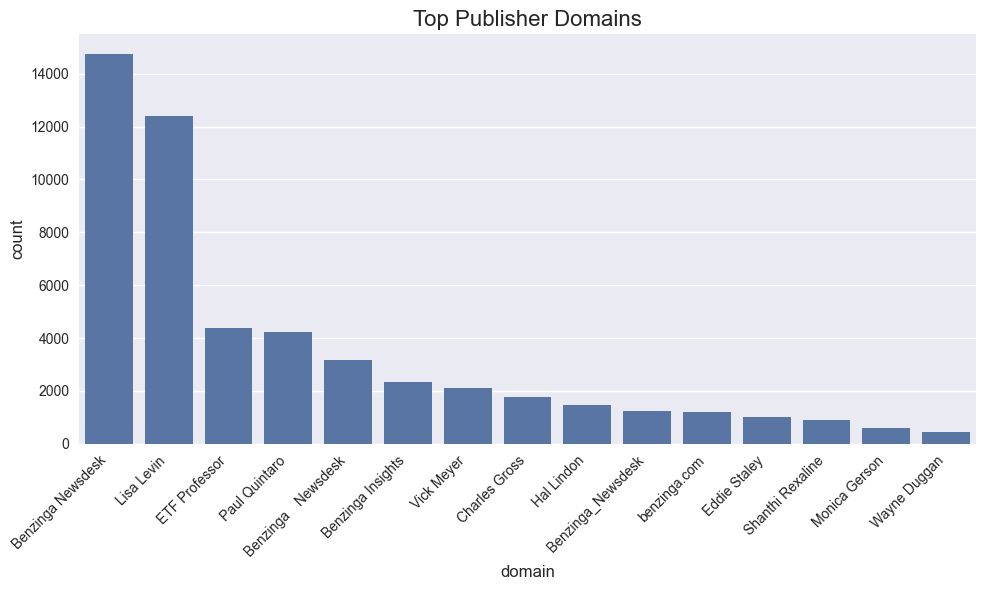

In [11]:
df = extract_publisher_domains(df)
domain_counts = df['publisher_domain'].value_counts()

print("Top Publisher Domains:")
print(domain_counts.head(10))

top_domains = domain_counts.head(15).reset_index()
top_domains.columns = ['domain', 'count']
plotter.bar(top_domains, x='domain', y='count', title='Top Publisher Domains')